In [28]:
import ee
import geopandas as gpd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

In [29]:
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-clowd')

In [30]:
shape_name="Ketapang"

# Path to the shapefile in Google Drive
shapefile_path = f'shape-file/{shape_name}/{shape_name}.shp'

# Load the shapefile using GeoPandas
gdf = gpd.read_file(shapefile_path)

# Convert the GeoPandas DataFrame to a GeoJSON
gdf = gdf.to_crs("EPSG:4326")  # Make sure the CRS is WGS84
geojson = gdf.__geo_interface__

# Convert GeoJSON to an Earth Engine FeatureCollection
geometry = ee.FeatureCollection(geojson)

In [31]:
# Filter the GLDAS ImageCollection
GLDAS = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G025/DA1D") \
                  .filterDate('2018-01-01', '2023-12-31') \
                  .filterBounds(geometry)

In [32]:
# Create a time-series with a trendline
def get_time_series(image_collection, region, scale, band):
    def reduce_region(image):
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=scale,
            bestEffort=True
        )
        return ee.Feature(None, {'date': image.date().format('YYYY-MM-dd'), 'value': stats.get(band)})
    
    reduced_collection = image_collection.map(reduce_region).filter(ee.Filter.notNull(['value']))
    features = reduced_collection.getInfo()['features']
    dates = [feature['properties']['date'] for feature in features]
    values = [feature['properties']['value'] for feature in features]
    
    return pd.DataFrame({'Date': pd.to_datetime(dates), 'Value': values})

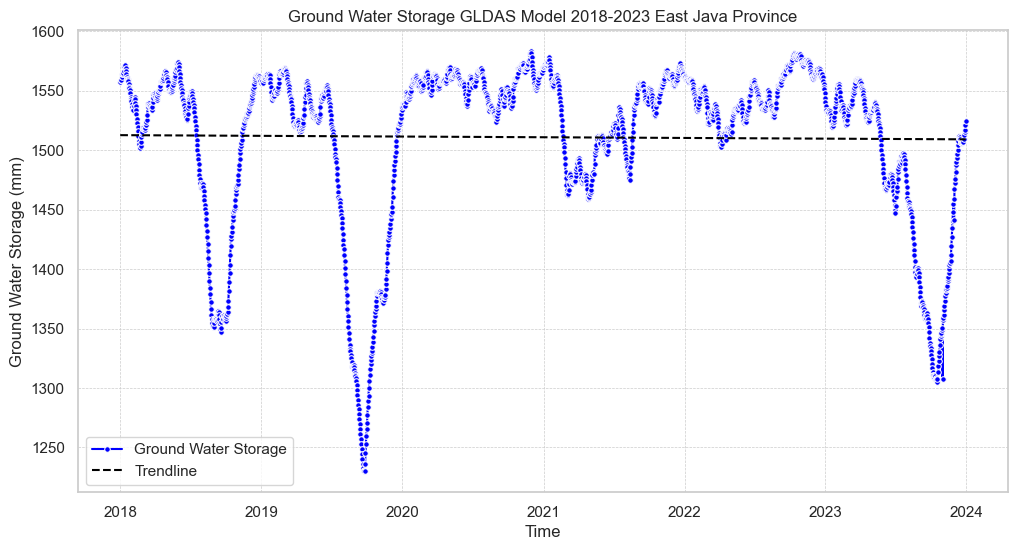

In [36]:
# Get the time series data
time_series = get_time_series(GLDAS.select('GWS_tavg'), geometry, 27830, 'GWS_tavg')

# Set the plot size and style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create the lineplot with seaborn
sns.lineplot(x='Date', y='Value', data=time_series, color='blue', label='Ground Water Storage', marker='o', markersize=4)

# Add a trendline
z = np.polyfit(time_series.index, time_series['Value'], 1)
p = np.poly1d(z)
plt.plot(time_series['Date'], p(time_series.index), '--', color='black', label='Trendline')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Ground Water Storage (mm)')
plt.title('Ground Water Storage GLDAS Model 2018-2023 East Java Province')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Display the plot
plt.show()

In [34]:
# Create a multi-year day-of-year series
def get_doy_series(image_collection, region, scale, band):
    def reduce_region(image):
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=scale,
            bestEffort=True
        )
        return ee.Feature(None, {'doy': image.date().getRelative('day', 'year').add(1), 'year': image.date().get('year'), 'value': stats.get(band)})
    
    reduced_collection = image_collection.map(reduce_region).filter(ee.Filter.notNull(['value']))
    features = reduced_collection.getInfo()['features']
    doys = [feature['properties']['doy'] for feature in features]
    years = [feature['properties']['year'] for feature in features]
    values = [feature['properties']['value'] for feature in features]
    
    return pd.DataFrame({'Day of Year': doys, 'Year': years, 'Value': values})

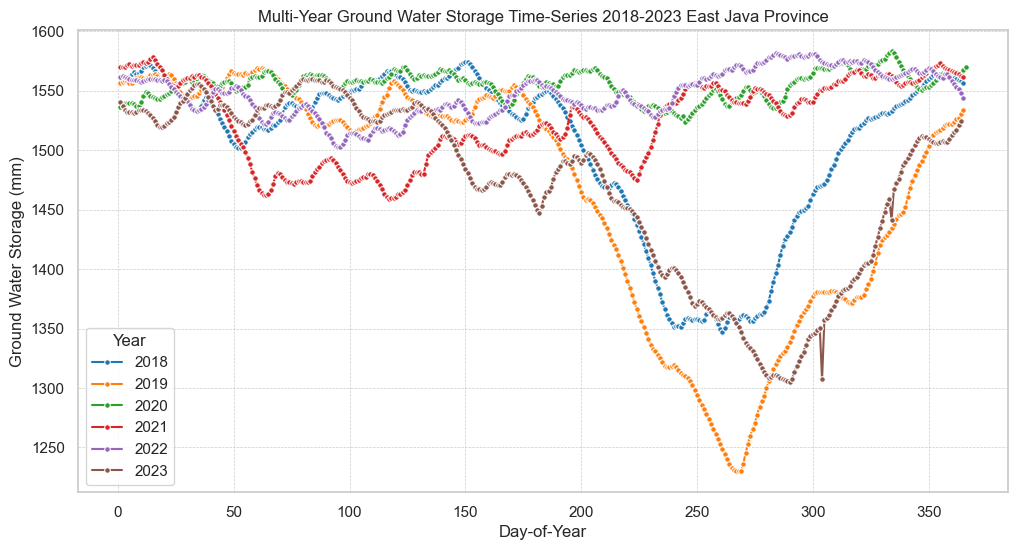

In [37]:
# Get the day-of-year series data
doy_series = get_doy_series(GLDAS.select('GWS_tavg'), geometry, 27830, 'GWS_tavg')

# Set the plot size and style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create the lineplot with seaborn
sns.lineplot(x='Day of Year', y='Value', hue='Year', data=doy_series, marker='o', markersize=4, palette='tab10')

# Customize the plot
plt.xlabel('Day-of-Year')
plt.ylabel('Ground Water Storage (mm)')
plt.title('Multi-Year Ground Water Storage Time-Series 2018-2023 East Java Province')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Year')

# Display the plot
plt.show()